# PRP325 Reach Analysis

## Table Of Contents
* [Executive Summary](#Executive-Summary)
* [Getting The Data](#Getting-the-data)
* [Graphical Analysis](#Graphical-Analysis)
* [Data Analysis](#Data-Analysis)
* [Hypotheses](#Hypotheses)
  * [Are precipitation events correlated with salinity spikes?](#Are-precipitation-events-correlated-with-salinity-spikes?)
  * [Hypothesis 2](#Hypothesis-2)
* [Conclusion](#Conclusion)
* [References](#References)

## Working Notes (10/29/2024)

- Make df not globally editable, each cell should just init a copy of the raw one
- 
- I am failing to find correlation with the fit versus the expected, can we reliably use the formula given across a distance? In other words, is salt at point A the same as salt at point B on a river if A and B are a sufficient distance away? I know that the Gulf Aquifer has wildly variate salinity (Black & Veatch)
- General procedure: Get data sources -> clean the data -> run models for time synchronization/mass balance -> format for offline analysis -> run graphical analysis -> run data analysis -> build hypotheses -> run a regression analysis to determine correlation -> derive explanations
- AFAIK We are lacking some data for Reach 2, however a relatively minute amount. Does this actually hinder the below investigation?
- TODO Hypotheses
  - Salinity is high when flow rates are low, check the release events for drains to see if a proportional salinity spike follows


# Executive Summary

## Goals

- Generate a series of well-formatted graphs that can provide a cursory analysis on the output from the OASIS model.
- Run summary statistical analysis on the time series
- Test certain hypotheses to see if they hold up

![ref.png](ref.png)

In [1]:
# Meta functions

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Import statements
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import gumbel_r
from sklearn.metrics import mutual_info_score

from src.lib import utils
from src.lib import stats
from src.lib import plot
from src.lib import analysis

In [3]:
# Global variables
pd.set_option('display.max_rows', 1000)

field_names = [
    "Upstream200.250",
    "DrenIndiosPuertecitos235.250",
    "Precipitation257.250",
    "DrenHuizaches285.300",
    "DrenMorrillo295.300",
    "GDOrdaz250.230",
    "UpperDemandTX250.240",
    "Evaporation250.255",
    "Phreatophyte250.245",
    "Downstream250.300",
    "Anzaldues300.280",
    "LowerDemandTX300.275",
    "MassBalance299.300",
    "MassBalanceOut300.298",
    "MassBalanceBalance300",
    "Salinity300",  # out
    "Salinity200",  # in
    "SalinityDrenPuertecitos",
    "SalinityDrenMorillos",
    "SalinityDrenHuizaches",
    "OtherInflow",
    "OtherOutflow"
]

# Getting the data

## Getting started

This project is managed with [Rye](https://rye.astral.sh/), follow the instructions there to get up and running with all the dependencies.

After installing the dependencies, you can just execute this notebook.

Some of this process is manual since OASIS does time sync, unit conversion and mass balance calculations.

- Get the data from OASIS using an uploaded `.1v` file. (Use the example `reach2_example.1v` and modify for your reach)
- Copy and paste the output data into `data/mass_balance_data.csv`.
- Remove any extraneous rows from the end of the file... OASIS can add precomputed averages which prevents the next command from working
- Run `rye run oasis2sqlite --csv data/mass_balance_data.csv --db mass_balance.sqlite`

## Fields Guide

**Note this includes computed fields from SQLite

| Field Name | Formula | Description |
|------------|---------|-------------|
| UpstreamFromR1 | flow200.250 | Inflow from upstream |
| IndiosPuertecitos | flow235.250 | Inflow from Indios Puertecitos |
| Precipitation | flow257.250 * 10| Precipitation input |
| DrenHuizaches | flow285.300 | Inflow from Dren Huizaches |
| DrenMorrillo | flow295.300 | Inflow from Dren Morrillo |
| GDOrdaz | flow250.230 | Outflow to GD Ordaz |
| UpperDemandTX | flow250.240 | Upper demand for Texas |
| Evaporation | flow250.255 | Evaporation loss |
| PhreatophyteDemand | flow250.245 | Phreatophyte water demand |
| DownstreamToR3 | flow250.300 | Outflow downstream to R3 |
| AnzalduasCanal | flow300.280 | Outflow to Anzalduas Canal |
| LoDemandTX | flow300.275 | Lower demand for Texas |
| MassBalance | flow299.300 | Mass balance inflow |
| MassBalanceOut | flow300.298 | Mass balance outflow |
| MassBalanceBalance | flow299.300 - flow300.298 | Net mass balance |
| SalinityOut | Timesers(arriba_anzalduas/salinity) | Salinity at outflow |
| SalinityIn | Timesers(rgccmb/salinity) | Salinity at inflow |
| SalinityDrenPuertecitos | Timesers(puertecitos/salinity) | Salinity at Dren Puertecitos|
| SalinityMorillos | Timesers(morillos/salinity) | Salinity at Dren Morillo |
| SalinityHuizaches | Timesers(huizaches/salinity) | Salinity at Dren Huizaches |
| OtherInflow | DrenIndiosPuertecitos235.250 + DrenHuizaches285.300 + DrenMorrillo295.300 | Sum of other inflows |
| OtherOutflow | Phreatophyte250.245 + UpperDemandTX250.240 + LowerDemandTX300.275 + Evaporation250.255 | Sum of other outflows |



In [4]:
# Connect to the database
conn = sqlite3.connect("mass_balance2.sqlite")

In [5]:
df = utils.sqlite2df(conn, "mass_balance")

# Graphical Analysis

## Observations

- This was an extra [rainy year](https://www.weather.gov/media/bro/wxevents/2021/pdf/RGV2021SummerSummary.pdf)
- Anzalduas Dam had large outflows that I'm guessing corresponded with the [planting season](https://hidalgo.agrilife.org/files/2020/09/Vegetable-Planting-Guide-for-Rio-Grande-Valley.pdf)
- MassBalanceOut heavily correlates with MassBalanceError... is this a result of the formula, or is there an error in the model?

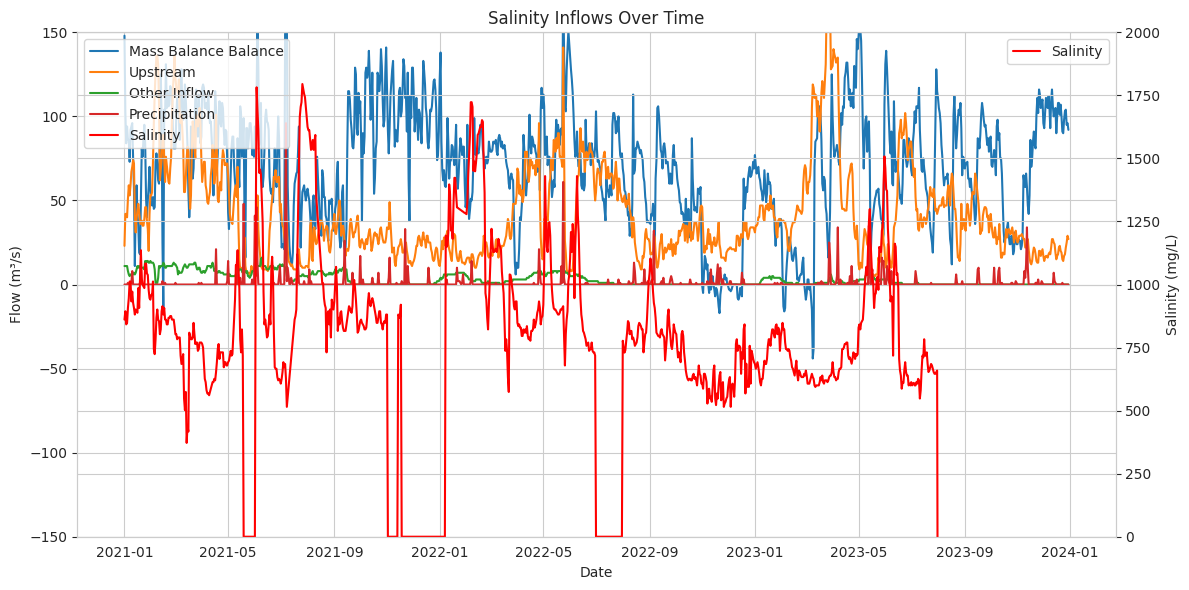

In [6]:
plot.get_inflow_salinity(conn)

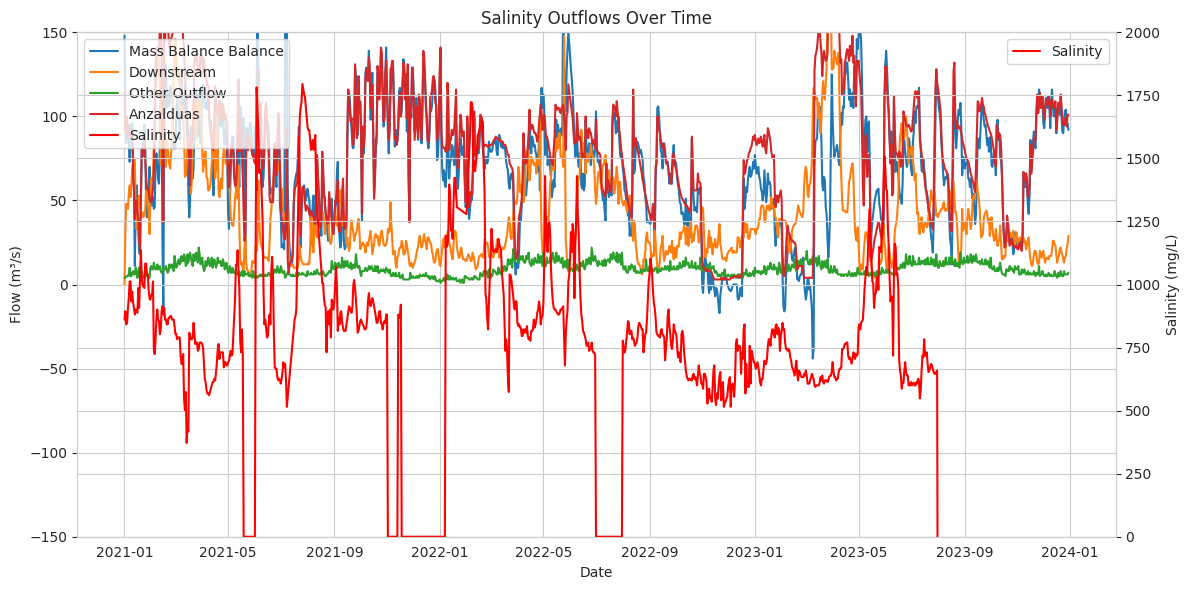

In [7]:
plot.get_outflow_salinity(conn)

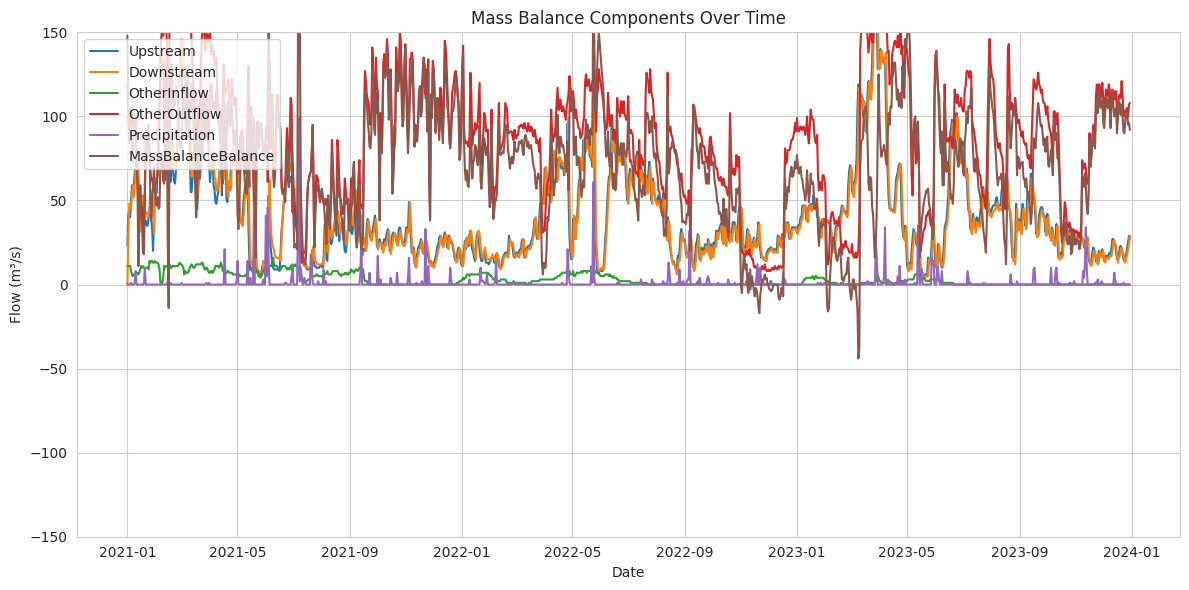

In [8]:
plot.mass_balance(conn)

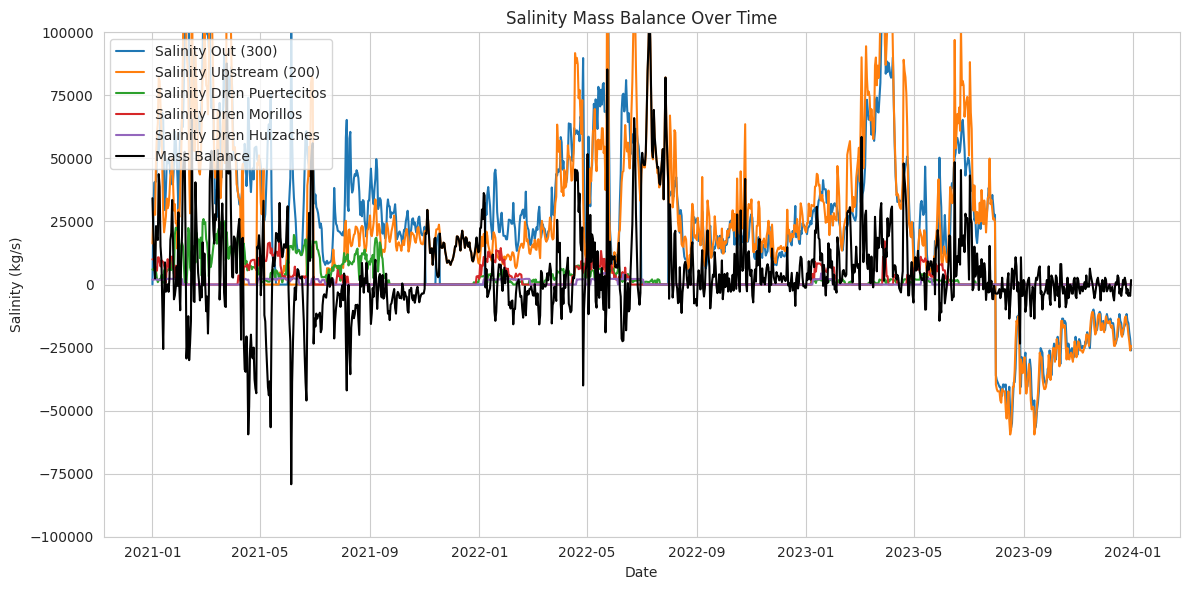

In [9]:
plot.plot_salinity_mass_balance(df.dropna())

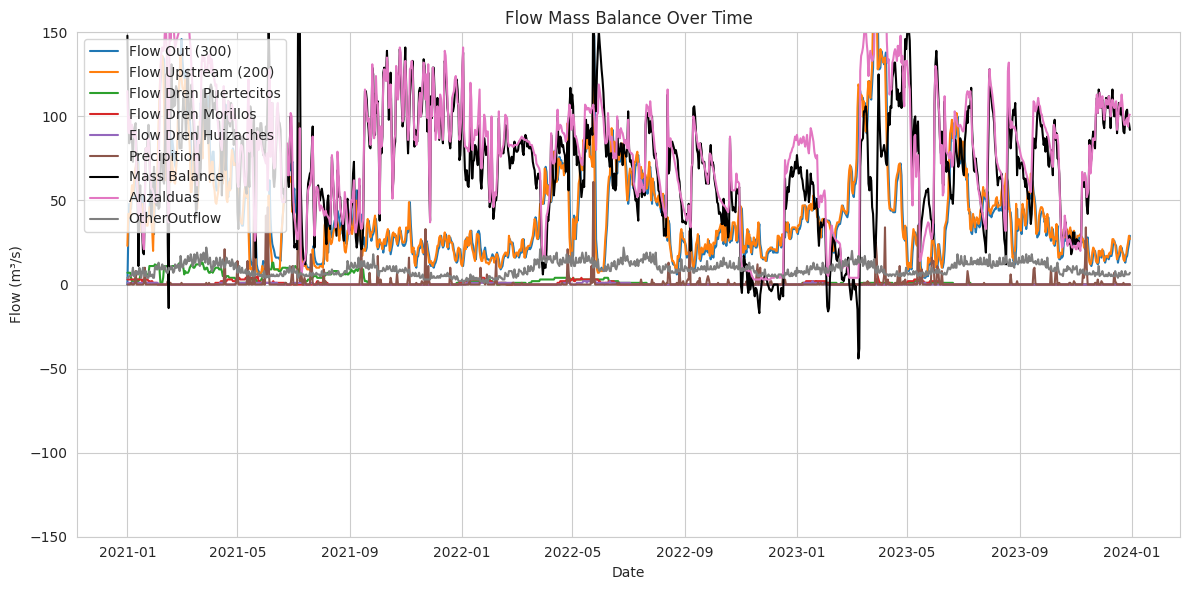

In [10]:
plot.plot_flow_mass_balance(df.dropna())

## Event Analysis

Take the salinity and flows and check for plausable events

- Salinity and flow for Dren Morillos is negatively correlated, but it seems like this isn't true for flows
- There are steady gains from Puertecitos that seem to correlate with the diff in the flow_in vs flow_out
- In the beginning of June there is a spike in rainfall that leads to a lagged (a day or so) spike in flows
- The salt in is consistently lower than the salt out, this gap seems to widen during rainfall events significantly esp start of June
- There is a loss of water during high flows, but during mid May there is a reversal of this (gain of water right before a drop in flows). Does this mean that the flow time is off?

In [11]:
analysis.moving_average(analysis.add_lag(df["DrenIndiosPuertecitos235.250"],1), 2).corr(analysis.moving_average(df["Upstream200.250"] - df["Downstream250.300"], 2))

np.float64(-0.40796998343572516)

# Data Analysis

## Goals

- Investigate the nature of the components
- Understand the null values or if there is bad data
- Assert model correctness

## Observations

- Most of the data is not normally distributed (a Pearson correlation might be inappropriate)
- Some of the data is nonstationary (meaning there are trends/seasonality); Evaporation, Phreatophytes, Dren Morrillo, Downstream. I bet that a wider timescale would reveal more seasonality
- For the stationary data, series auto-correlate heavily with a day or two lag. This makes sense because it takes time for water to move

In [12]:
# Clean the data
df = df.replace(-9999., pd.NA)  # Null values for salinity are this
df = df.dropna()

# Prevent certain functions from yelling at me
# TODO: This might be inaccurate -- Get the story of the data!
df = df.replace(0.0, 1e-9)

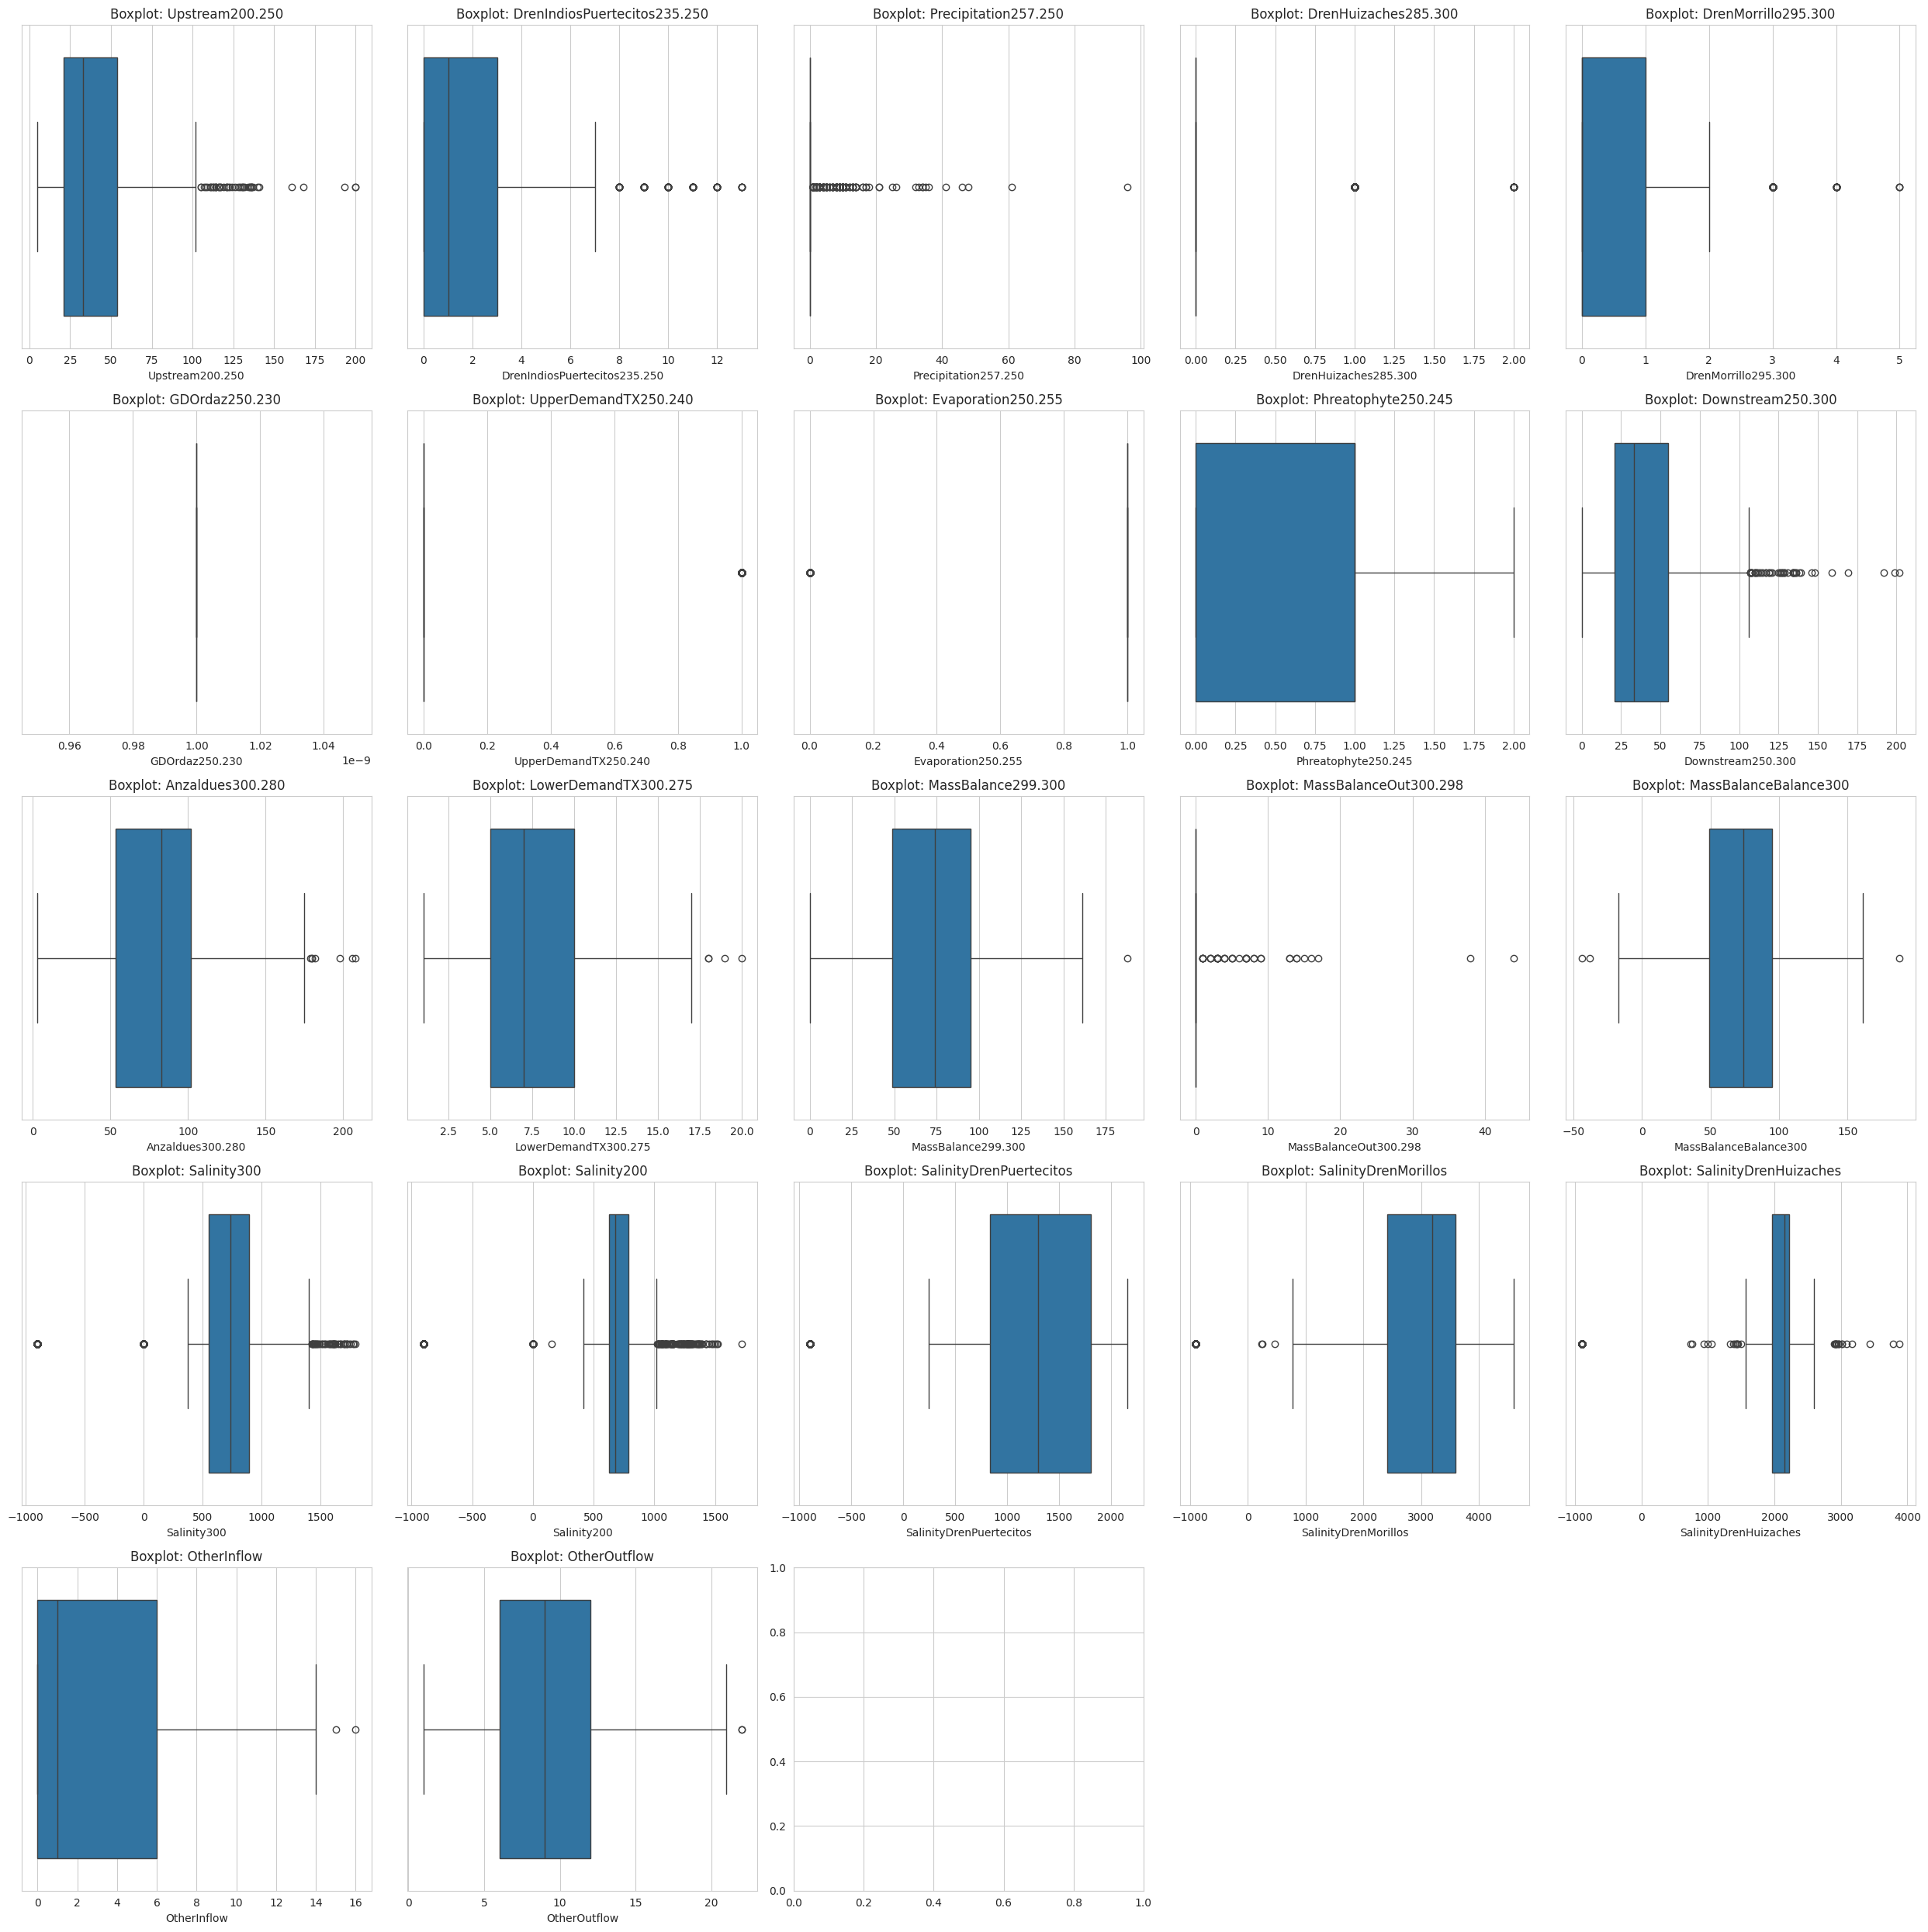

In [13]:
stats.plot_boxplot(df, field_names)

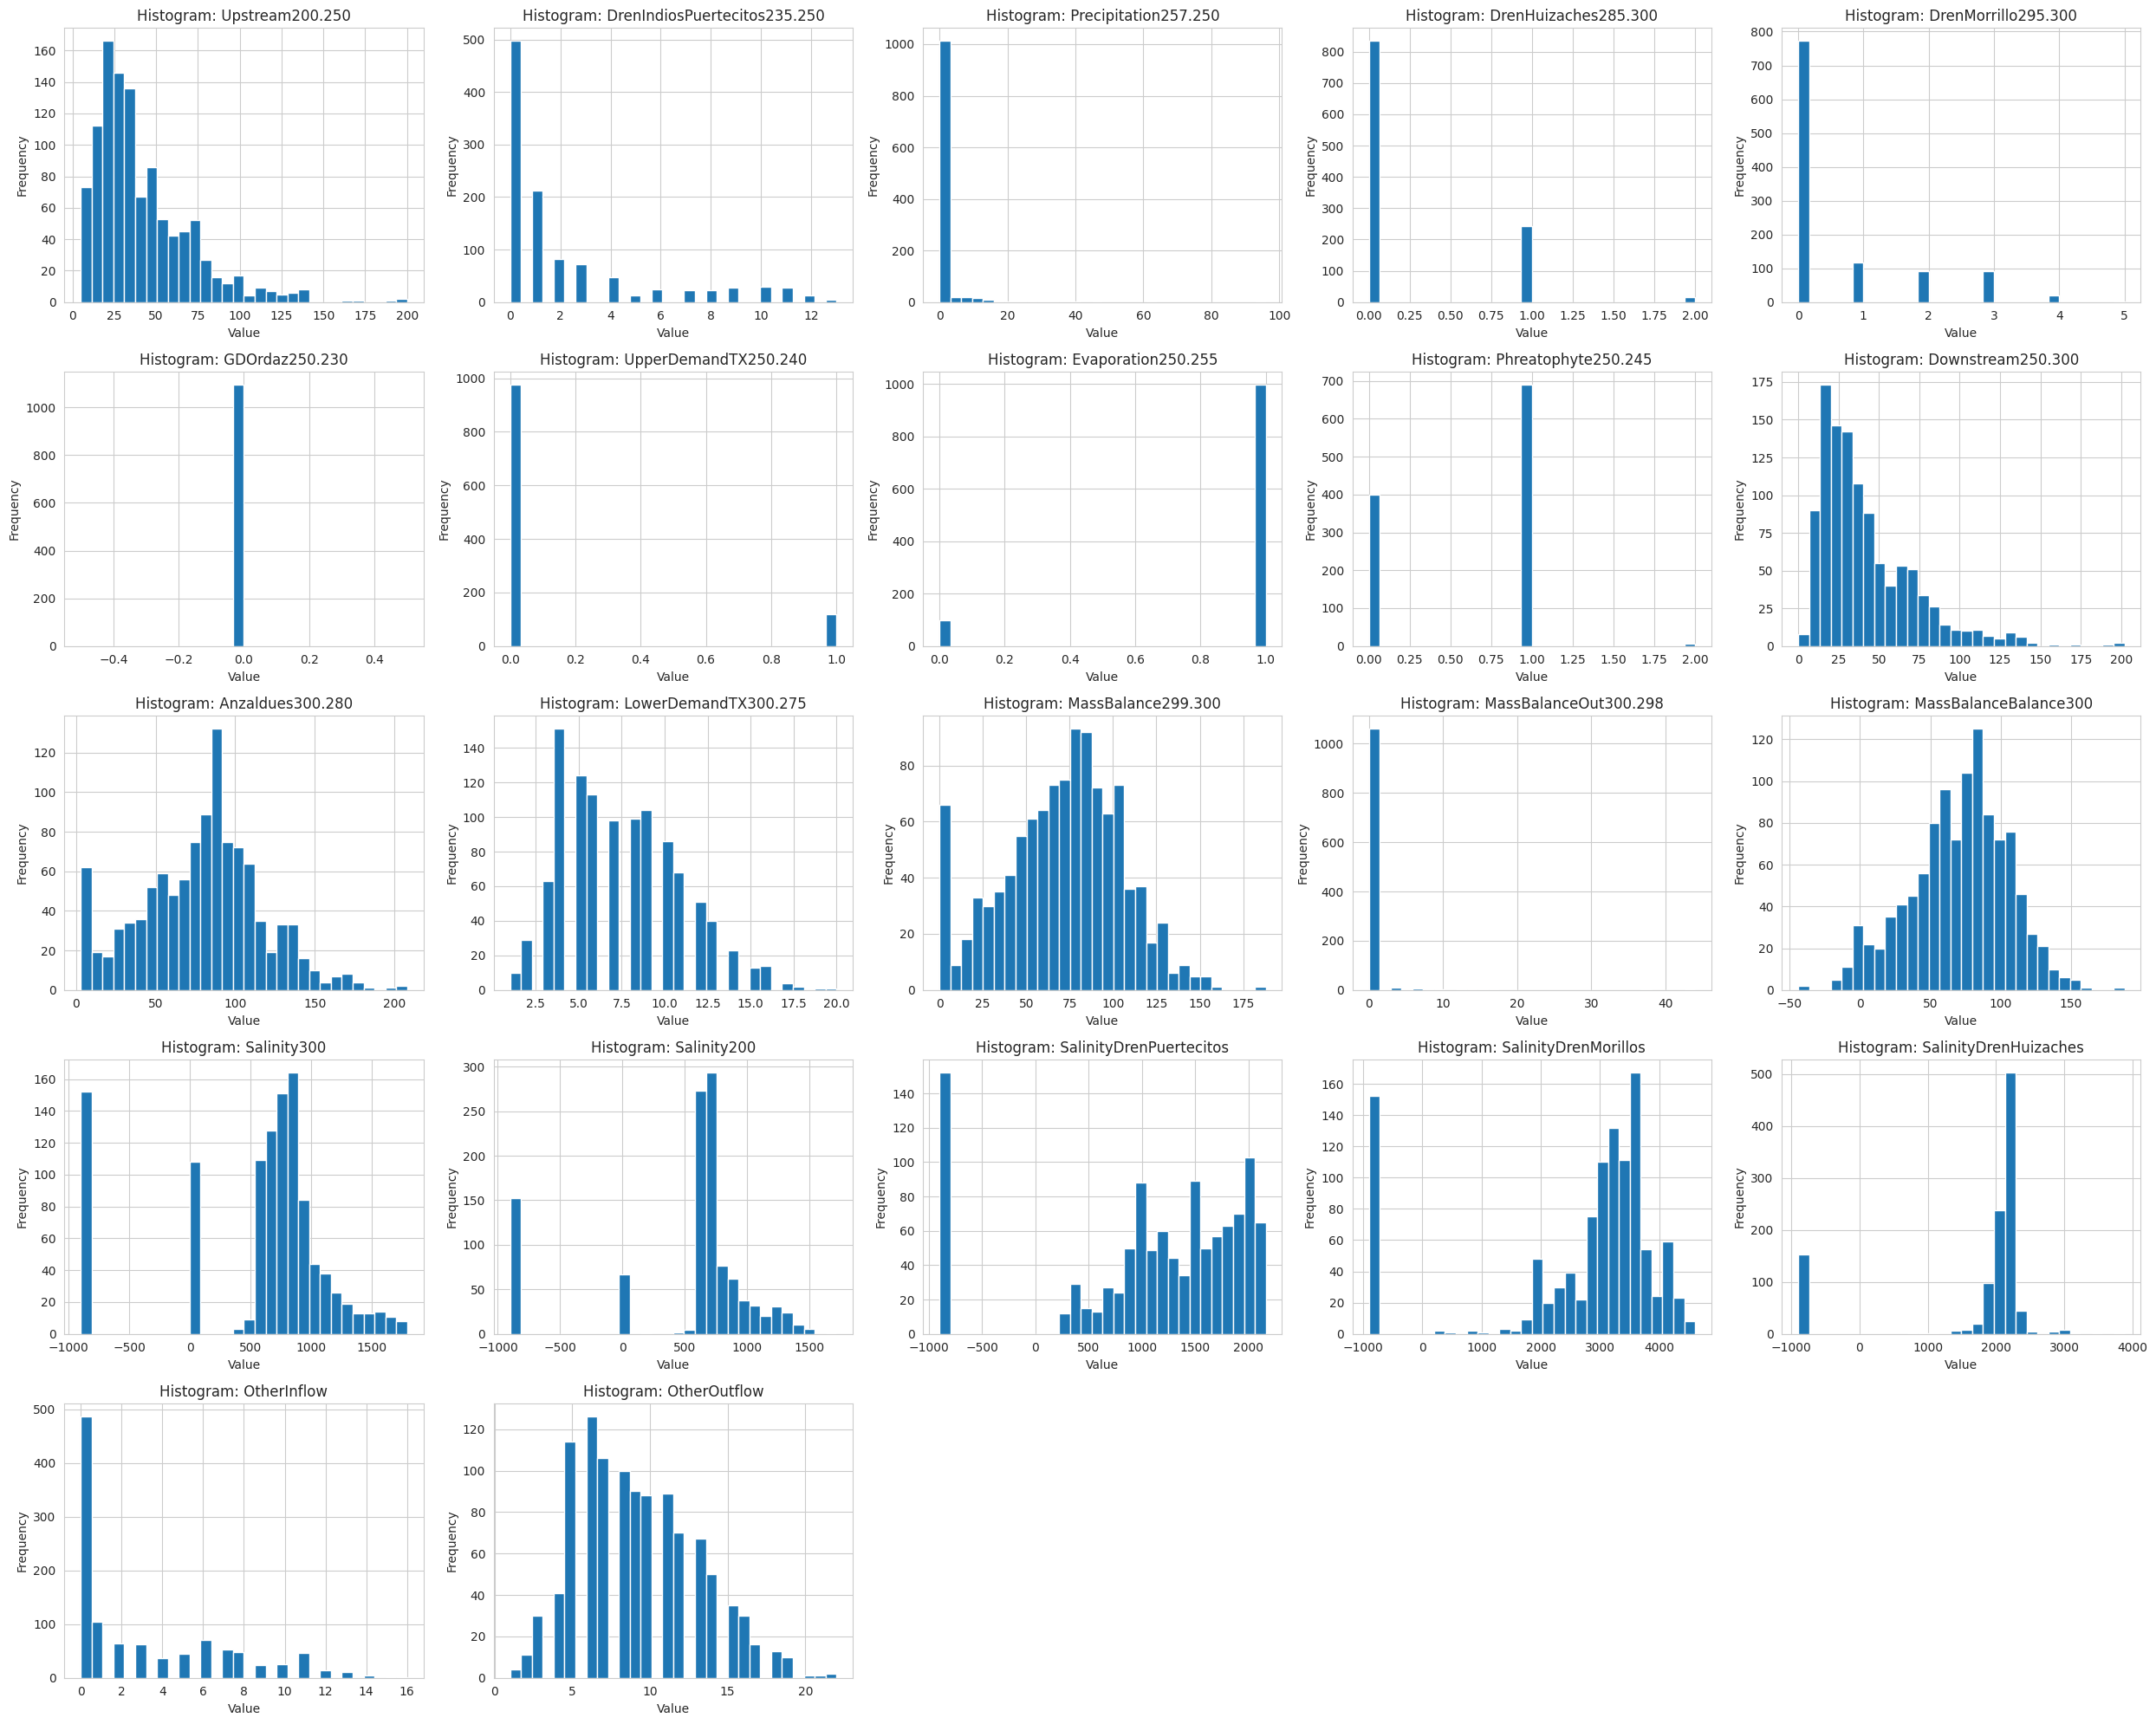

In [14]:
stats.plot_histogram(df, field_names)

<Axes: >

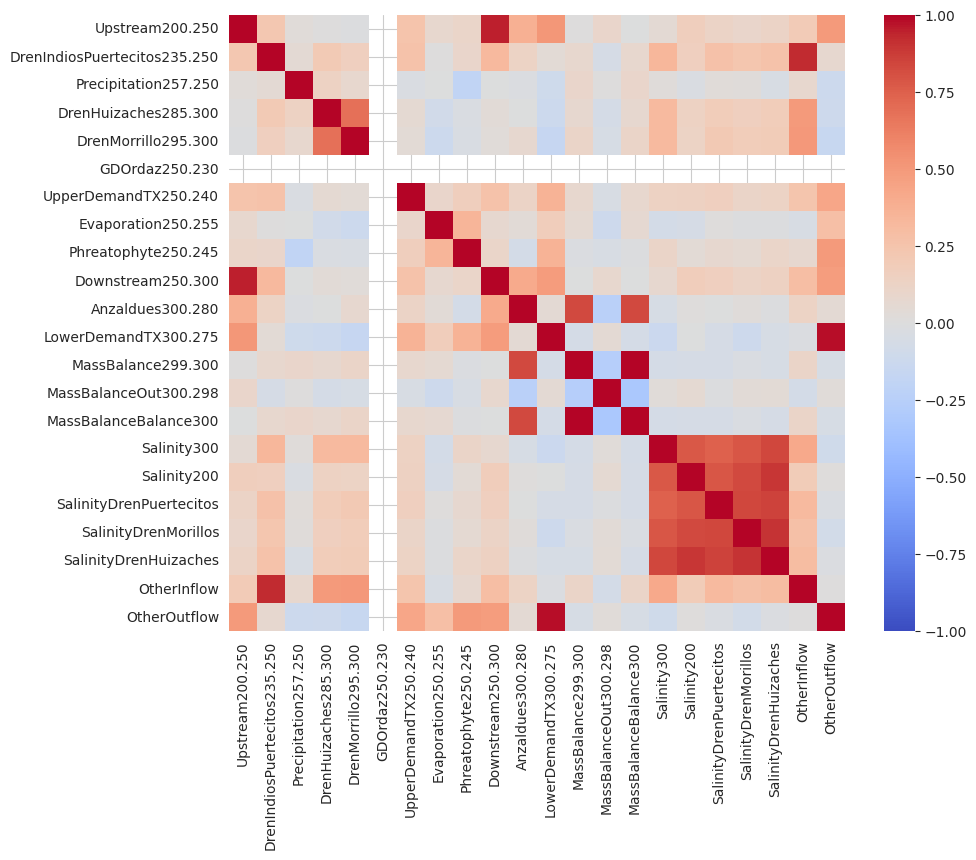

In [15]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm', vmin=-1, vmax=1, center=0, square=True)

# Hypotheses

## Goals

- Assert hypotheses from the above analyses.
- Support or deny the hypothesis, or be inconclusive

## Are precipitation events correlated with salinity spikes?

There is an observation from the graphical analysis that salinity spikes seem to occur after rainfall. To test this hypothesis, I check the error based on the salinity formula given for local drainage including the 2 day moving average of the precipitation flows on the river surface as `flow_local` (just to smooth things). From this I approximate the c_local using parameterized curve fitting. 

$$
    c_{out} = \frac{c_{in} \cdot flow_{in} + c_{local} \cdot flow_{local}}{flow_{out}}
$$

### Takeaways

It is inconclusive whether or not precipitation events are significant, both the cache basin and the on-the-river precipitation are either not good proxies of the actual impact, there is an issue with the experiment setup, or the correlation is actually indicative.

Optimized parameter: 9.980379576842975e-16
Length of y_data_valid: 1093
Length of y_fit_valid: 1093
Unique values in y_data_valid: 392
Unique values in y_fit_valid: 1041
Mean Squared Error: 2111105.2021630392
Mean Absolute Error: 1392.5642264412604
Pearson Correlation: -0.744171400949904
Spearman Correlation: nan


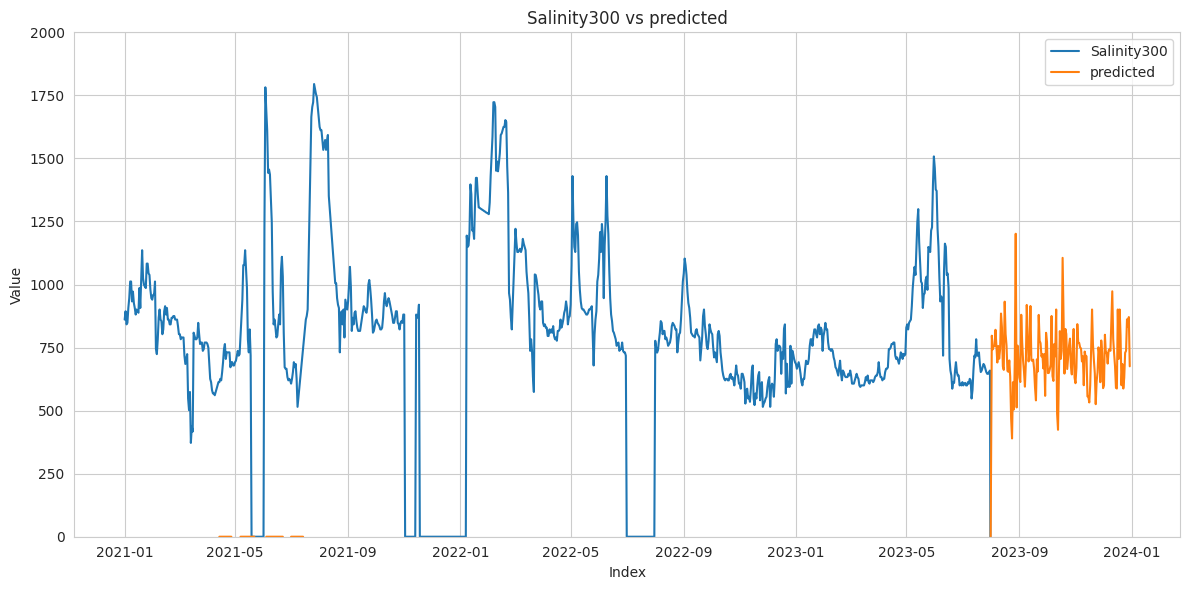

In [16]:
# Known values for the other parameters (these are fixed for the fitting process)
flow_local = analysis.moving_average(df["Precipitation257.250"], 2)
flow_in = df["Upstream200.250"]
c_in = analysis.moving_average(df["Salinity200"],2)
flow_out = df["Downstream250.300"] + df["OtherOutflow"]
x_data = np.array([flow_local, flow_in, flow_out, c_in])

# Fit the curve on c_local, adjusting it to minimize the error
# Compare against smoothed salinity
# Median Salinity For Non-Point Sources in stormwater runoff (Dirrigl et al, 2016)
optimal_sal = analysis.regression_error(
    model_function=analysis.base_salinity_function,
    x_data=x_data,
    y_data=analysis.moving_average(df["Salinity300"],2),
    p0=[671.],
    bounds=((0,10000)),
)

df["predicted"] = analysis.base_salinity_function(
    X=x_data,
    c_local=optimal_sal,
)

# Plot the predicted function over the points
plot.plot_two_columns(df, "Salinity300", "predicted", smooth=False)

### That looks okay... but definitely doesn't support the conclusion

How about we also use the HUC data from Miguel Pavon covering the cache basin? The map below show AOI 2N/2S

![ref2.jpg](ref2.jpg)

In [17]:
# Supplemental information on rainfall in the entire cache basin (not just on the surface)
# Assumes rye run huc2sqlite has been run with all relevant AOI

df_huc_2N = pd.read_csv("data/Rain_Ave_Date_2N.csv", header=0)
df_huc_2S = pd.read_csv("data/Rain_Ave_Date_2S.csv", header=0)

df_huc_2N['timestamp'] = pd.to_datetime(df_huc_2N['Date_Text'], format='%Y%m%d')
df_huc_2S['timestamp'] = pd.to_datetime(df_huc_2S['Date_Text'], format='%Y%m%d')

# Join the data together on the timestamp
df_huc = df_huc_2N[["timestamp"]].assign(mean_precip=df_huc_2N["mean_precip"] + df_huc_2S["mean_precip"])

# Filter out irrelevant rows based on timestamp
start = pd.to_datetime("01/01/2021")
end = pd.to_datetime("12/31/2021")
df_huc = df_huc[(df_huc['timestamp'] >= start) & (df_huc['timestamp'] <= end)]

# Update the index to be the timestamp
df_huc.set_index('timestamp', inplace=True)

# Optional: Sort the index (timestamps) if needed
df_huc.sort_index(inplace=True)

# Add to the main df
df["AOI_rainfall"] = df_huc["mean_precip"]

Optimized parameter: 1.0502813828599904e-14
Length of y_data_valid: 364
Length of y_fit_valid: 364
Unique values in y_data_valid: 201
Unique values in y_fit_valid: 360
Mean Squared Error: 1697698.577458036
Mean Absolute Error: 1208.872302747639
Pearson Correlation: 0.10724553756458469
Spearman Correlation: nan


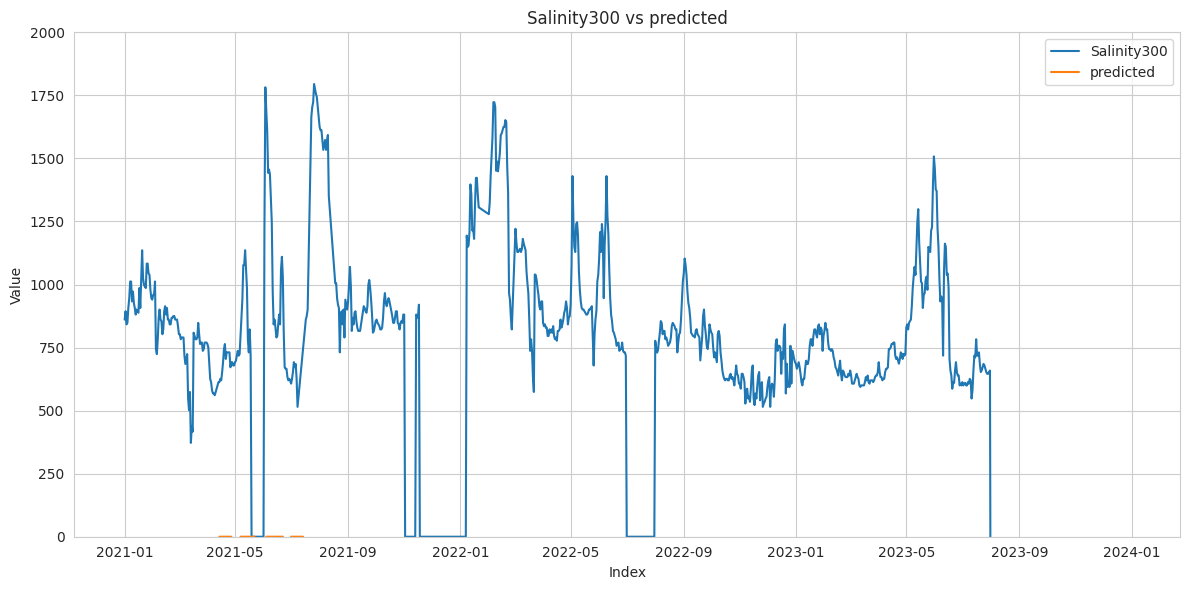

In [18]:
# Known values for the other parameters (these are fixed for the fitting process)
flow_local = analysis.moving_average(df["AOI_rainfall"], 2) 
flow_in = df["Upstream200.250"]
c_in = analysis.moving_average(df["Salinity200"],2)
flow_out = df["Downstream250.300"] + df["OtherOutflow"]
x_data = np.array([flow_local, flow_in, flow_out, c_in])

# Fit the curve on c_local, adjusting it to minimize the error
# Compare against smoothed salinity
# Median Salinity For Non-Point Sources in stormwater runoff (Dirrigl et al, 2016)
optimal_sal = analysis.regression_error(
    model_function=analysis.base_salinity_function,
    x_data=x_data,
    y_data=analysis.moving_average(df["Salinity300"],2),
    p0=[671.],
    bounds=((0,10000)),
)

df["predicted"] = analysis.base_salinity_function(
    X=x_data,
    c_local=optimal_sal,
)

# Plot the predicted function over the points
plot.plot_two_columns(df, "Salinity300", "predicted", smooth=False)

## Gumbel Distribution

@Suggestion from Miguel Duran

Use [the Gumbel Distribution](https://en.wikipedia.org/wiki/Gumbel_distribution) so that we can better approximate the behavior of extreme events

Requirements:
- Sample each week -- maximum peak (need at least 30)
- Fit the data to the distribution
- Find correlation between two distributions


In [19]:
def gumbel_corr(size=1000, loc1=0, scale1=1, loc2=0, scale2=1):
    """
    Computes the empirical Pearson and Spearman correlation between two Gumbel-distributed variables.

    Parameters:
    - size: int, number of samples to generate.
    - loc1, scale1: float, parameters for the first Gumbel distribution.
    - loc2, scale2: float, parameters for the second Gumbel distribution.
    
    Returns:
    - pearson_corr: float, Pearson correlation coefficient.
    - spearman_corr: float, Spearman correlation coefficient.
    """
    # Generate samples from two independent Gumbel distributions
    gumbel1 = gumbel_r.rvs(loc=loc1, scale=scale1, size=size)
    gumbel2 = gumbel_r.rvs(loc=loc2, scale=scale2, size=size)
    
    # Compute Pearson correlation
    pearson_corr = np.corrcoef(gumbel1, gumbel2)[0, 1]
    
    # Compute Spearman correlation (rank-based, can handle non-linear relationships)
    spearman_corr = np.corrcoef(np.argsort(gumbel1), np.argsort(gumbel2))[0, 1]
    
    return pearson_corr, spearman_corr

In [20]:
weekly_max = df.resample("3d").max()
loc1, scale1 = gumbel_r.fit(weekly_max["Salinity300"].dropna().astype(int))
loc2, scale2 = gumbel_r.fit(weekly_max["Precipitation257.250"].dropna().astype(int))

gumbel1 = gumbel_r.rvs(loc=loc1, scale=scale1, size=1000)
gumbel2 = gumbel_r.rvs(loc=loc2, scale=scale2, size=1000)
print(f"Salinity fit: {loc1}, {scale1}")
print(f"Precip fit: {loc2}, {scale2}")
print(f"Cov: {np.cov(gumbel1, gumbel2)}")

def discretize_data(data, bins=50):
    return np.digitize(data, np.histogram(data, bins=bins)[1])

# Compute mutual information
mutual_info = mutual_info_score(discretize_data(gumbel1), discretize_data(gumbel2))
print(f"Mutual Information: {mutual_info}")

Salinity fit: 191.28777710250125, 793.8670445982477
Precip fit: 0.7590000597575025, 2.788932067995474
Cov: [[ 9.87268668e+05 -1.63221804e+02]
 [-1.63221804e+02  1.27671059e+01]]
Mutual Information: 0.46350008955383204


In [21]:
gumbel_corr(int(loc1), int(scale1), int(loc2), int(scale2))

/home/badmin/pa325/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/badmin/pa325/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


(np.float64(nan), np.float64(0.18601715348580877))

## Simple Plotting (With segments - lack of segments means lack of fit)

/home/badmin/pa325/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/badmin/pa325/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/badmin/pa325/src/lib/analysis.py:163: RuntimeWarning: invalid value encountered in accumulate
  px_init = np.r_[np.r_[xmin, seg].cumsum(), xmax]
/home/badmin/pa325/src/lib/analysis.py:169: RuntimeWarning: invalid value encountered in accumulate
  px = np.r_[np.r_[xmin, seg].cumsum(), xmax]
/home/badmin/pa325/.venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:834: RuntimeWarning: invalid value encountered in subtract
  if (np.max(np.ravel(np.abs(sim[1:] - sim[0]))) <= xatol and
/home/badmin/pa325/.venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:839: RuntimeWarning: invalid value encountere

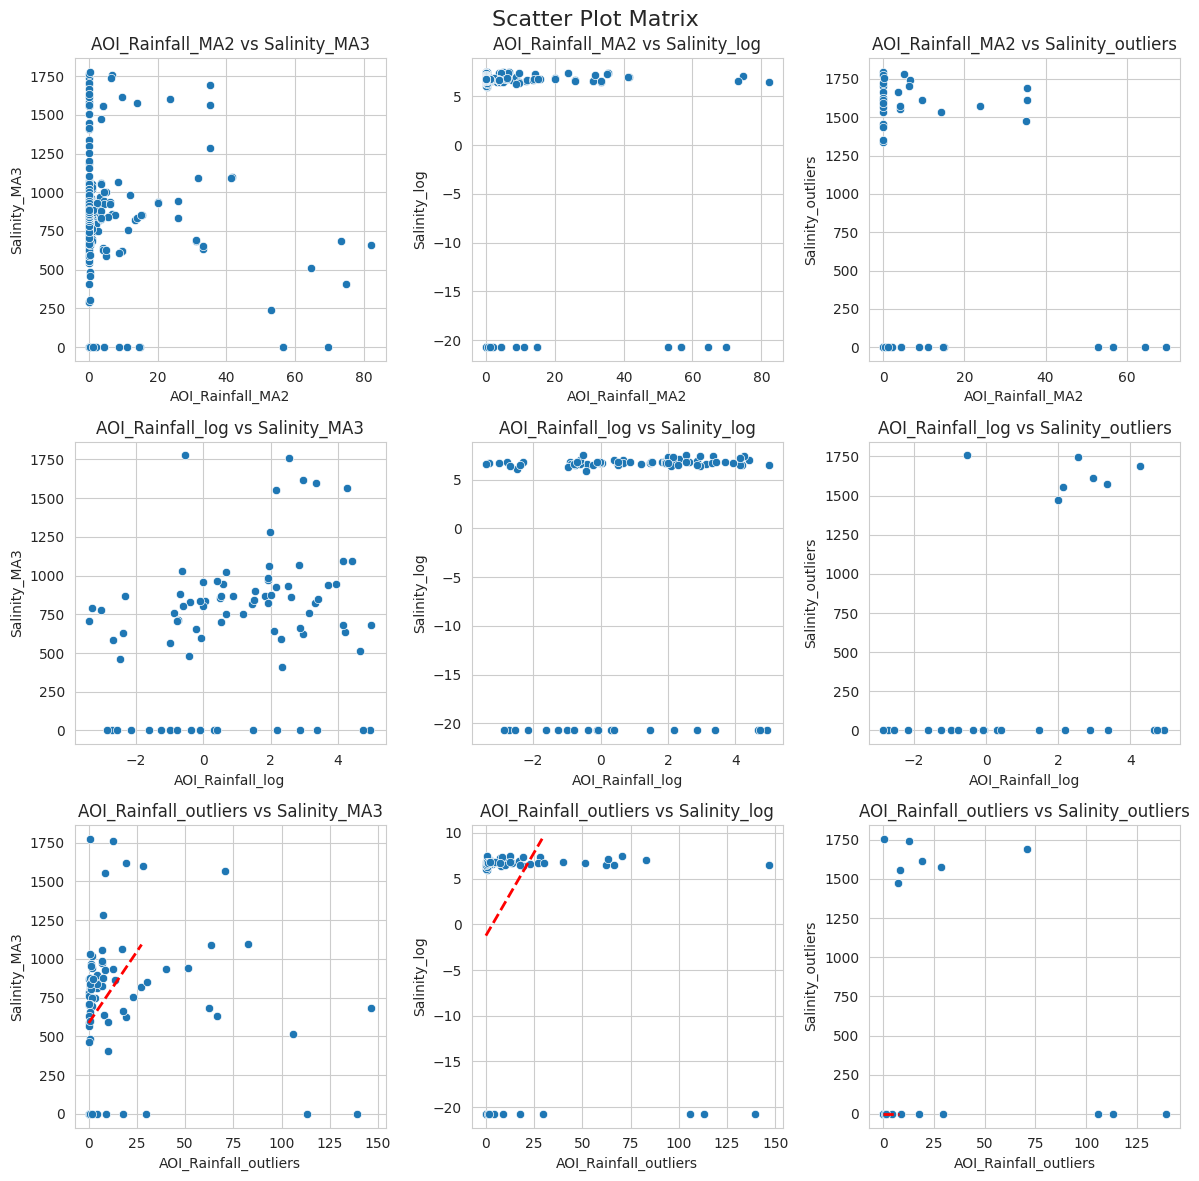

In [22]:
# Add precipitation transforms
df_plots = df.copy()
max_days = 5
for i in range(2,max_days):
    df_plots[f"AOI_Rainfall_MA{i}"] = analysis.moving_average(df["AOI_rainfall"], i)
    df_plots[f"Salinity_MA{i}"] = analysis.moving_average(df["Salinity300"], i)
    df_plots[f"AOI_Rainfall_max{i}"] = df["AOI_rainfall"].resample(f"{i}d").max()
    df_plots[f"Salinity_max{i}"] = df["Salinity300"].resample(f"{i}d").max()

df_plots[f"AOI_Rainfall_outliers"] = analysis.keep_outliers(df["AOI_rainfall"], multiplier=1.25)
df_plots[f"Salinity_outliers"] = analysis.keep_outliers(df["Salinity300"], multiplier=1.25)
df_plots[f"AOI_Rainfall_log"] = np.log(df["AOI_rainfall"].dropna().astype(float))
df_plots[f"Salinity_log"] = np.log(df["Salinity300"].dropna().astype(float))

plot.scatter(
    df_plots, 
    [f"AOI_Rainfall_MA2", f"AOI_Rainfall_log", f"AOI_Rainfall_outliers"], 
    [f"Salinity_MA3", f"Salinity_log", f"Salinity_outliers"],
    grid_width=3,
    plot_piecewise=True,
    piecewise_count=5
)

## Log Transform

Using the $ \log $ transform (14) of the salt differences, try to establish a correlation.

#### Log Transform Derivation

**Assume all local inflows have the same salinity, and all outflows have the salinity at the downstream gauge.**

Given by the water mass balance model, we have:

1) $$flow_{in} + flow_{local} = flow_{out}$$

Assume that all terms in $ flow_{out} $ are the same salinity $ sal_{out} $, define the salt mass balance:

2) $$ flow_{out} (sal_{out}) = flow_{in} (sal_{in}) + flow_{local} (sal_{local}) $$

Let the relative salinity concentrations at $ sal_{out} $ and $ sal_{local} $ be defined as:

3) $$ \Delta sal_{out} = sal_{out} - sal_{in} $$

4) $$ \Delta sal_{local} = sal_{local} - sal_{in} $$

Substituting (3) leads to:

5) $$ flow_{out} (sal_{out}) = flow_{out} (sal_{in} + \Delta sal_{out}) $$

Substituting (4) leads to:

6) $$ flow_{out} (sal_{out}) = flow_{in} (sal_{in}) + flow_{local} (sal_{in} + \Delta sal_{local}) $$

Taking (5) and (6) leads to:

7) $$ flow_{out} (sal_{in} + \Delta sal_{out}) = flow_{in} (sal_{in}) + flow_{local} (sal_{in} + \Delta sal_{local}) $$

Substituting for $ flow_{out} $ from (1):

8) $$ (flow_{in} + flow_{local})(sal_{in} + \Delta sal_{out}) = flow_{in} (sal_{in}) + flow_{local} (sal_{in} + \Delta sal_{local}) $$

Expand both sides:

9) $$ flow_{in} (sal_{in}) + flow_{in} (\Delta sal_{out}) + flow_{local} (sal_{in}) + flow_{local} (\Delta sal_{out}) = flow_{in} (sal_{in}) + flow_{local} (sal_{in}) + flow_{local} (\Delta sal_{local}) $$

Eliminate like terms:

10) $$ flow_{in} (\Delta sal_{out}) + flow_{local} (\Delta sal_{out}) = flow_{local} (\Delta sal_{local}) $$

Substitute $ flow_{out} $ from (1):

11) $$ flow_{out} ( \Delta sal_{out} ) = flow_{local} (\Delta sal_{local}) $$

Which can be rewritten as:

12) $$ \Delta sal_{out} = \frac{flow_{local} (\Delta sal_{local})}{flow_{out}} $$

Take the $ \log $ of both sides:

13) $$ \log ( \Delta sal_{out} ) = \log ( \frac{flow_{local} (\Delta sal_{local})}{flow_{out}} ) $$

Expand the terms: 

14) $$ \log ( \Delta sal_{out} ) = \log ( \Delta sal_{local} ) + \log ( flow_{local} ) - \log ( flow_{out} )$$


In [23]:
# Known values for the other parameters (these are fixed for the fitting process)
flow_local = df["Precipitation257.250"] + df["OtherInflow"]
flow_in = df["Upstream200.250"]
c_in = df["Salinity200"]
# Translate the chart to avoid negative values
delta_c_out = np.log(df["Salinity300"].astype(float) - df["Salinity200"].astype(float))
flow_out = -1 * (df["Downstream250.300"] + df["OtherOutflow"])
x_data = np.array([flow_local, flow_out, c_in])

# Fit the curve on c_local, adjusting it to minimize the error
# Compare against smoothed salinity
# Median Salinity For Non-Point Sources in stormwater runoff (Dirrigl et al, 2016)
optimal_c_local = analysis.regression_error(
    model_function=analysis.log_transform_sal_diff,
    x_data=x_data,
    y_data=delta_c_out,
    p0=[671.],
    bounds=((0,4000)),
)

df["log_predicted"] = analysis.log_transform_sal_diff(
    X=x_data,
    c_local=optimal_c_local,
)

# Plot the predicted function over the points
df["delta_c_out"] = delta_c_out
plot.plot_two_columns(df, "delta_c_out", "log_predicted", smooth=False, y_lim=20)

/home/badmin/pa325/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/badmin/pa325/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/badmin/pa325/src/lib/analysis.py:38: RuntimeWarning: divide by zero encountered in log
  return np.log(safe_sal_diff) + np.log(flow_local) - np.log(flow_out)
/home/badmin/pa325/src/lib/analysis.py:38: RuntimeWarning: invalid value encountered in log
  return np.log(safe_sal_diff) + np.log(flow_local) - np.log(flow_out)
/home/badmin/pa325/src/lib/analysis.py:26: SyntaxWarning: invalid escape sequence '\l'
  """


ValueError: Residuals are not finite in the initial point.

Eq. (12) can also be written as:

15) $$ \Delta sal_{out} = sal_{local}(\frac{flow_{local}}{flow_{out}}) - sal_{in}(\frac{flow_{local}}{flow_{out}})$$

It is also possible to take (12) and do the cube root:

16) $$ \sqrt[3]{\Delta sal_{out}} = \sqrt[3]{\frac{flow_{local} (\Delta sal_{local})}{flow_{out}}} $$

In [ ]:
# Known values for the other parameters (these are fixed for the fitting process)
df_ma = weekly_max.dropna()

print(df_ma.head())

flow_local = df_ma["Precipitation257.250"]
flow_in = df_ma["Upstream200.250"]
c_in = df_ma["Salinity200"]

# Translate the chart to avoid negative values
delta_c_out = np.log(df_ma["Salinity300"].astype(float) - df_ma["Salinity200"].astype(float) + 3000)
flow_out = -1 * (df_ma["Downstream250.300"] + df_ma["OtherOutflow"])
x_data = np.array([flow_local, flow_out, c_in])

# Fit the curve on c_local, adjusting it to minimize the error
# Compare against smoothed salinity
# Median Salinity For Non-Point Sources in stormwater runoff (Dirrigl et al, 2016)
optimal_c_local = analysis.regression_error(
    model_function=analysis.log_transform_sal_diff,
    x_data=x_data,
    y_data=delta_c_out,
    p0=[671.],
    bounds=((0,4000)),
)

df_ma["log_predicted"] = analysis.log_transform_sal_diff(
    X=x_data,
    c_local=optimal_c_local,
)

# Plot the predicted function over the points
df_ma["delta_c_out"] = delta_c_out
plot.plot_two_columns(df_ma, "delta_c_out", "log_predicted", smooth=False, y_lim=20)

## There is a loss of water during periods of high flow leading to salinity increases

asdfasfdasfd

## Dren Puertecitos contributes to salinity differences

Following (2)

# Conclusions

# References